In [1]:
## Imports


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight');
import pandas as pd
import pickle

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.metrics import mean_squared_error, r2_score

from prophet import Prophet

plt.figure(figsize=(8, 16), dpi=80);


<Figure size 640x1280 with 0 Axes>

In [2]:
monthly_df=pd.read_csv('monthly_energy_consumption.csv',
                      index_col=[0],parse_dates=True)
monthly_df.head()

,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


## Loading the dataframe with previous RMSE where we stored results

In [3]:
results=pd.read_csv('scores.csv',index_col=[0])

# Splitting train and test

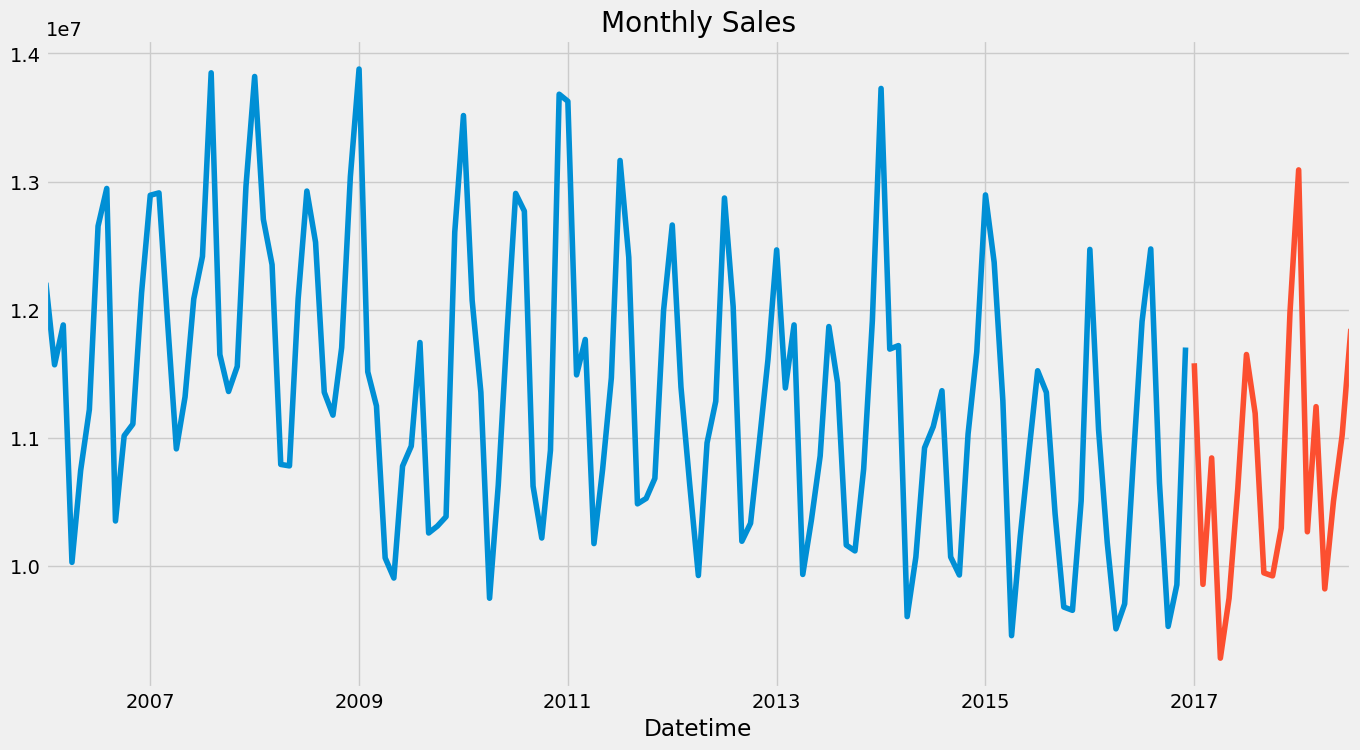

In [4]:
#let's take a look to our data before we start making predictions
train=monthly_df.loc['2006':'2016'].copy()
test=monthly_df.loc['2017':'2018'].copy()
train.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14);

# Second collection of Models in Time Series: <a id='start'></a>

* These methods do not provide any depth. They just take one value as a reference and project it all the way into the future.

    1. [**ARIMA**](#arima). AR stands for AutoRegressive, I for Integrated and MA for moving average.We have to define p,d,q<br>
    2. [**SARIMA**](#sarima). We are going to be adding Seasonality to ARIMA. We need to define apart from ARIMA's pdq, PDQ and S<br>
    3. [**FBProphet**](#prophet). Algorithm introduce by facebook (currently Menta) that is effective and easy to apply<br>


<a id='arima'></a>
## 1. ARIMA.
[back top](#start)

In [5]:
# We need stationarity and we check it with adfuller. If p_value is below our significance level we reject null hypothesis and it is #stationary.

def selecting_d(ts):
    selected_d=0
    for d in range(7):
        if d==0:
            diff=ts
        else:
            diff=ts.diff(d).dropna()
        #print(d, adfuller(diff)[1])
        if adfuller(diff)[1]<0.05:
            selected_d=d
            return selected_d
selected_d=selecting_d(train.energy)
best_rmse = 99 *(10**16)
best_p =0
best_q =0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
  for q in range(5):
       # Fitting an ARIMA(p, 1, q) model.
      #print(f'Attempting ARIMA({p}, {selected_d}, {q})')

      # Instantiate and fit ARIMA model.
      model = ARIMA(endog=train.energy.to_period('M'),order=(p,selected_d,q)).fit()
      preds=model.predict(start=test.index[0],
                      end=test.index[-1]).values
      rmse=np.sqrt(mean_squared_error(test,preds))
      # Print out AIC for ARIMA(p, 1, q) model.
      #print(f'The RMSE for ARIMA({p},{selected_d},{q}) is: {rmse}')

      # Is my current model's AIC better than our best_aic?
      if rmse < best_rmse:

          # If so, let's overwrite best_aic, best_p, and best_q.
          best_rmse = rmse
          best_p = p
          best_q = q
print('MODEL FINISHED!')
print(f'Our model that minimizes RMSE on the training data is the ARIMA({best_p},{selected_d},{best_q}).')
print(f'This model has an RMSE of {best_rmse}.')
model=ARIMA(train.energy.to_period("M"), 
            order=(best_p,selected_d,best_q),
           enforce_stationarity=False,
           enforce_invertibility=False).fit()
models={'ARIMA': (best_p,selected_d,best_q)}
#pickling my model:
with open ('best_models.pkl','wb') as file:
    pickle.dump(models,file)
    

MODEL FINISHED!
Our model that minimizes RMSE on the training data is the ARIMA(2,1,3).
This model has an RMSE of 708478.0293083435.


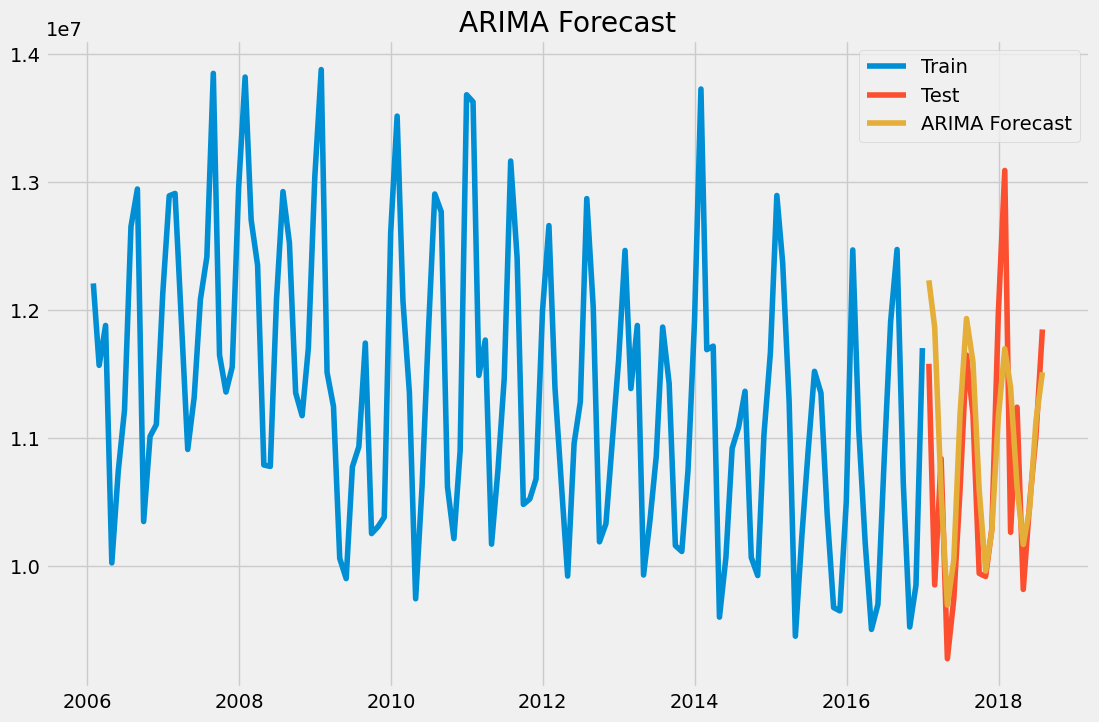

In [6]:
preds=test.copy()
preds['arima']=model.predict(start=test.index[0], end=test.index[-1]).values
preds
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['arima'], label='ARIMA Forecast')
plt.legend(loc='best')
plt.title("ARIMA Forecast");

In [7]:
rms_arima = round(np.sqrt(mean_squared_error(test.energy, preds.arima)),2)
results.loc['arima']=rms_arima/1_000_000
results.sort_values('rmse_per_million')


,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id='sarima'></a>
## 2. SARIMA.
[back top](#start)

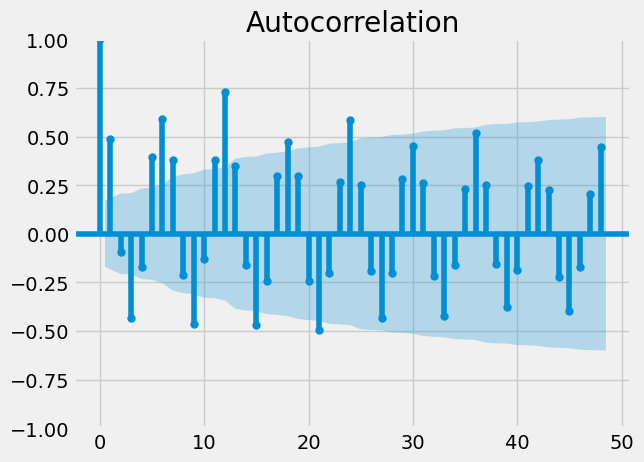

In [9]:
#What about the tiny s? I am going to plot partial autocorrelation.
plot_acf(train,lags=48); #looks like every 12 it picks up

In [11]:
#We will define D applying the afuller criteria to the seasonal component.
S=12
outcome = seasonal_decompose(train, model='additive',extrapolate_trend='freq')
selected_D=selecting_d(outcome.seasonal)

#What about P and Q: Looping


# We need stationarity and we check it with adfuller. If p_value is below our significance level we reject null hypothesis and it is #stationary.

best_rmse = 99 *(10**16)
best_P =0
best_Q =0
count=0
# Use nested for loop to iterate over values of p and q.
for P in range(5):
  for Q in range(5):

      # Instantiate and fit ARIMA model.
      msarima = SARIMAX(endog= train.energy,
                  order = (best_p, selected_d, best_q),              # (p, d, q)
                  seasonal_order= (P, selected_D, Q, 12)).fit(disp=0,method='cg') # (P, D, Q, S)
      preds=msarima.predict(start=test.index[0],
                      end=test.index[-1]).values
      rmse=np.sqrt(mean_squared_error(test,preds))
      count+=1
      print('COUNT: ',count)  
      # Is my current model's RMSE better than our best_aic?
      if rmse < best_rmse:

          best_rmse = rmse
          best_P = P
          best_Q = Q
print('MODEL FINISHED!')
print(f'Our model that minimizes RMSE on the training data is the SARIMA({best_P},{selected_D},{best_Q},{S}).')
print(f'This model has an RMSE of {best_rmse}.')
model=SARIMAX(train.energy.to_period("M"), 
            order=(best_p,selected_d,best_q),
              seasonal_order=(best_P,selected_D,best_Q,S),
           enforce_stationarity=False,
           enforce_invertibility=False).fit(disp=0)
models={'SARIMAX': [(best_p,selected_d,best_q),(best_P,selected_D,best_Q,S)]}
#pickling my model:
with open ('best_models.pkl','wb') as file:
    pickle.dump(models,file)
print('DONE')

MODEL FINISHED!
Our model that minimizes RMSE on the training data is the SARIMA(4,0,1,12).
This model has an RMSE of 638400.5863278959.


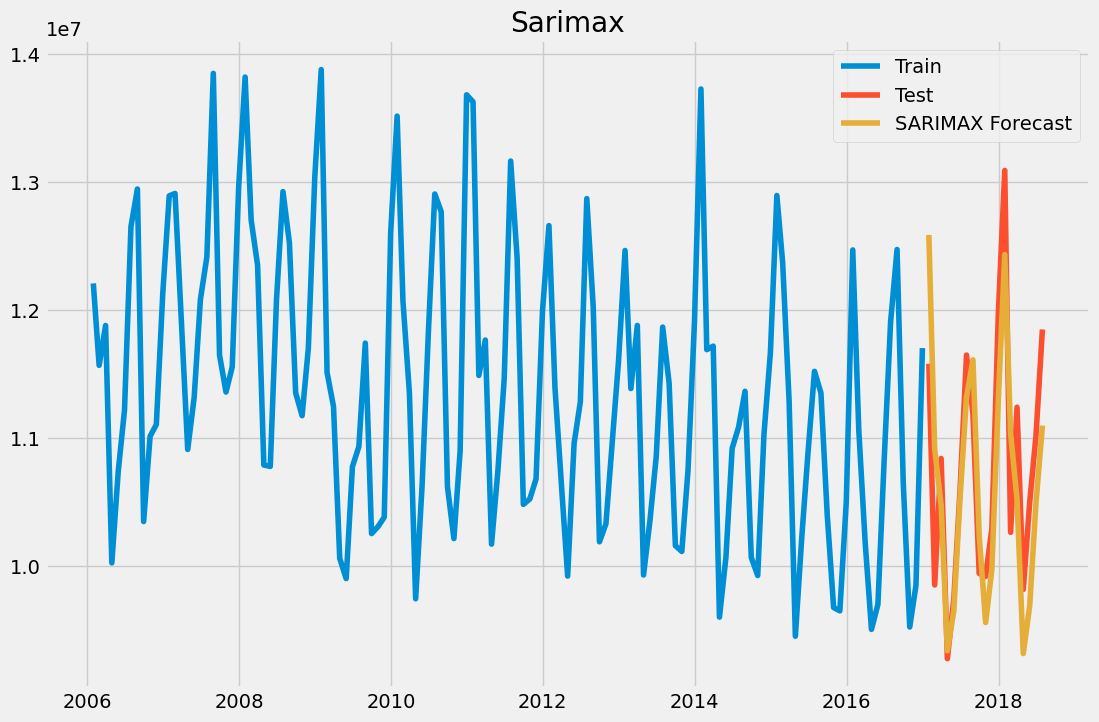

In [12]:
preds=model.predict(start=test.index[0],
                      end=test.index[-1]).values
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(test.index,preds, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title("Sarimax");

In [13]:
rms_sarimax = round(np.sqrt(mean_squared_error(test.energy, preds)),2)
results.loc['SARIMAX']=rms_sarimax/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id='prophet'></a>
## 3. FBProphet.
[back top](#start)

13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


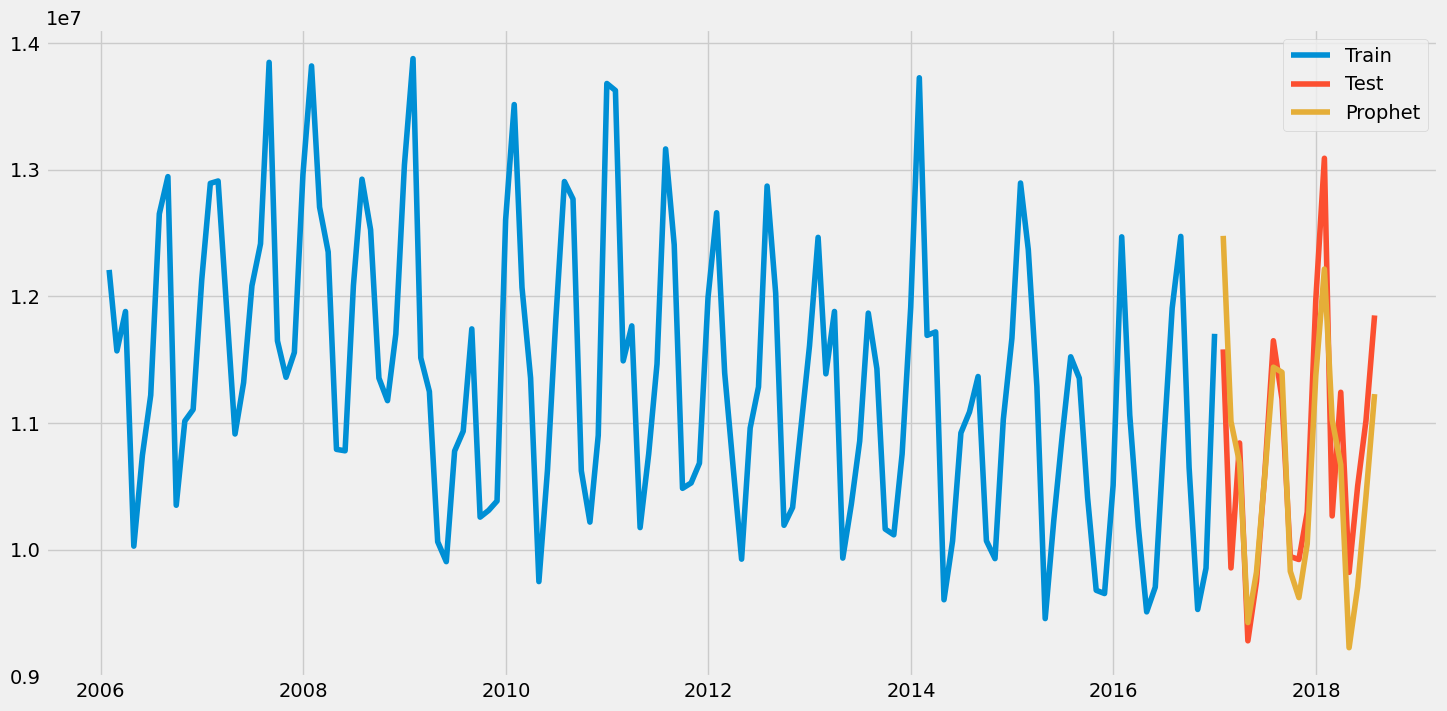

In [14]:
#Prophet

seasonality=12

freq='M'
####Prepping for Prophet
pro_train=train.reset_index()

pro_train.rename(columns={'energy':'y','Datetime':'ds'}, inplace = True)
pro_train['y'] = np.log(pro_train['y'])
model = Prophet()
model.fit(pro_train)
future = model.make_future_dataframe(periods=len(test), freq = 'M')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(len(test)).values
pro_preds=np.exp(pro_preds)
pro_preds
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(test.energy.index,pro_preds, label='Prophet')
plt.legend(loc='best')
plt.show()

In [15]:
rms_prophet = round(np.sqrt(mean_squared_error(test.energy, pro_preds)),2)
results.loc['prophet']=rms_prophet/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


In [16]:
results.to_csv('scores.csv')